In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)


In [2]:
fname = 'D:/SLAC/hysteresis/magnet_characterization/1.26Q3.5_4034/strplt.ru1'

data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)

# get real h, m
h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double() * np.where(data[:,7] < 0, -1, 1)
h_train = h
m_train = m

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


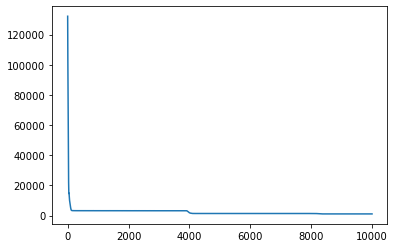

In [3]:
#train model using priors and MAP
from hysteresis.bayesian import BayesianHysteresis, positional_covariance
from hysteresis.training import map_bayes, train_bayes
import pyro

def cov(model):
    return positional_covariance(model, 1.0)

bh = BayesianHysteresis(train_h=h_train, train_m=m_train, mesh_scale=0.5)


guide, trace = map_bayes(bh, 10000, initial_lr=0.1)
plt.plot(trace)

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


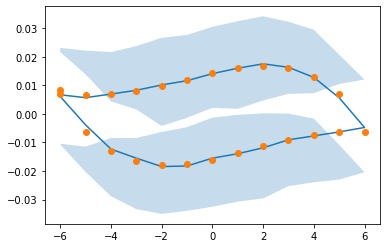

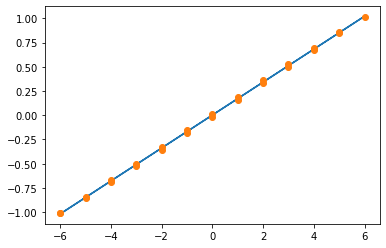

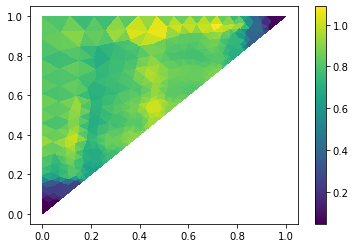

In [4]:
# make predictions
from hysteresis.bayesian_utils import predict, save_predictive, load_predictive
from hysteresis.visualization import plot_hysterion_density
pred_summary, samples = predict(h_train, bh, guide)
mean = pred_summary['obs']['mean']
l = pred_summary['obs']['5%']
u = pred_summary['obs']['95%']

fit_val = bh.transformer.poly_fit(h_train)

fig, ax = plt.subplots()
ax.plot(h_train, mean.detach() - fit_val)
ax.plot(h_train, m_train.detach() - fit_val,'o')
ax.fill_between(h_train, l - fit_val, u - fit_val, alpha=0.25)

fig2, ax2 = plt.subplots()
ax2.plot(h_train, fit_val.detach())
ax2.plot(h_train, m_train,'o')

fig3, ax3 = plot_hysteresis_density(
    bh,
    pred_summary['density']['mean'].flatten().detach()
)

C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.weights was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
C:\ProgramData\Miniconda3\envs\bayesian_hysteresis\lib\site-packages\pyro\primitives.py:440: UserWarning: poly_fit.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(


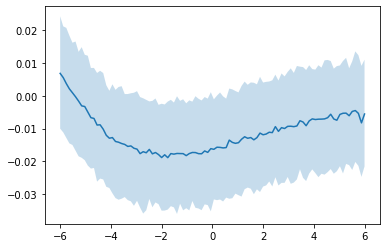

In [5]:
from hysteresis.bayesian_utils import summary
save_predictive(bh, guide)
pred = load_predictive('predictive.pt')
pred.model.future()

domain = pred.model.valid_domain
test_h = torch.linspace(*domain, 100)
norm_h = pred.model.transformer.transform(test_h)

samples = pred(test_h, return_real = True)
result = summary(samples)

fit_val = bh.transformer.poly_fit(test_h)
plt.plot(test_h, result['obs']['mean'] - fit_val)
plt.fill_between(test_h,
                 result['obs']['5%'] - fit_val,
                 result['obs']['95%'] - fit_val, alpha=0.25)